# 学習状況のチェック (jpeg)

学習に用いたjpgデータを推論の結果と合わせて表示する

In [1]:
TASK = 'off001'

In [2]:
import torch
import torchvision

MODEL = TASK+"_model.pth"

if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

device = torch.device(DEVICE)
output_dim = 2

model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, output_dim)

model = model.to(device)
model.load_state_dict(torch.load('data/'+TASK+'_A/'+MODEL))

<All keys matched successfully>

In [3]:
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import PIL.Image
import numpy as np

if DEVICE== 'cuda':
    mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
    std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
else:
    mean = torch.Tensor([0.485, 0.456, 0.406]).cpu()
    std = torch.Tensor([0.229, 0.224, 0.225]).cpu()   

def preprocess(image):
    device = torch.device(DEVICE)
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

In [4]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import re

DIR = "data/"
APEX = "apex"
CATEGORY = "A"

IMG_WIDTH = 224
IMG_HEIGHT = 224

# 読み込みを始める最初の数
start_pos = 0

path = DIR + TASK + "_" + CATEGORY + "/" + APEX
filenames = os.listdir(path)
#path = DIR + TASK + "_" + CATEGORY + "/" + APEX + '/*.jpg'
#filenames = glob.glob(path)

WIDTH = 8
HEIGHT = len(filenames) // WIDTH + 1

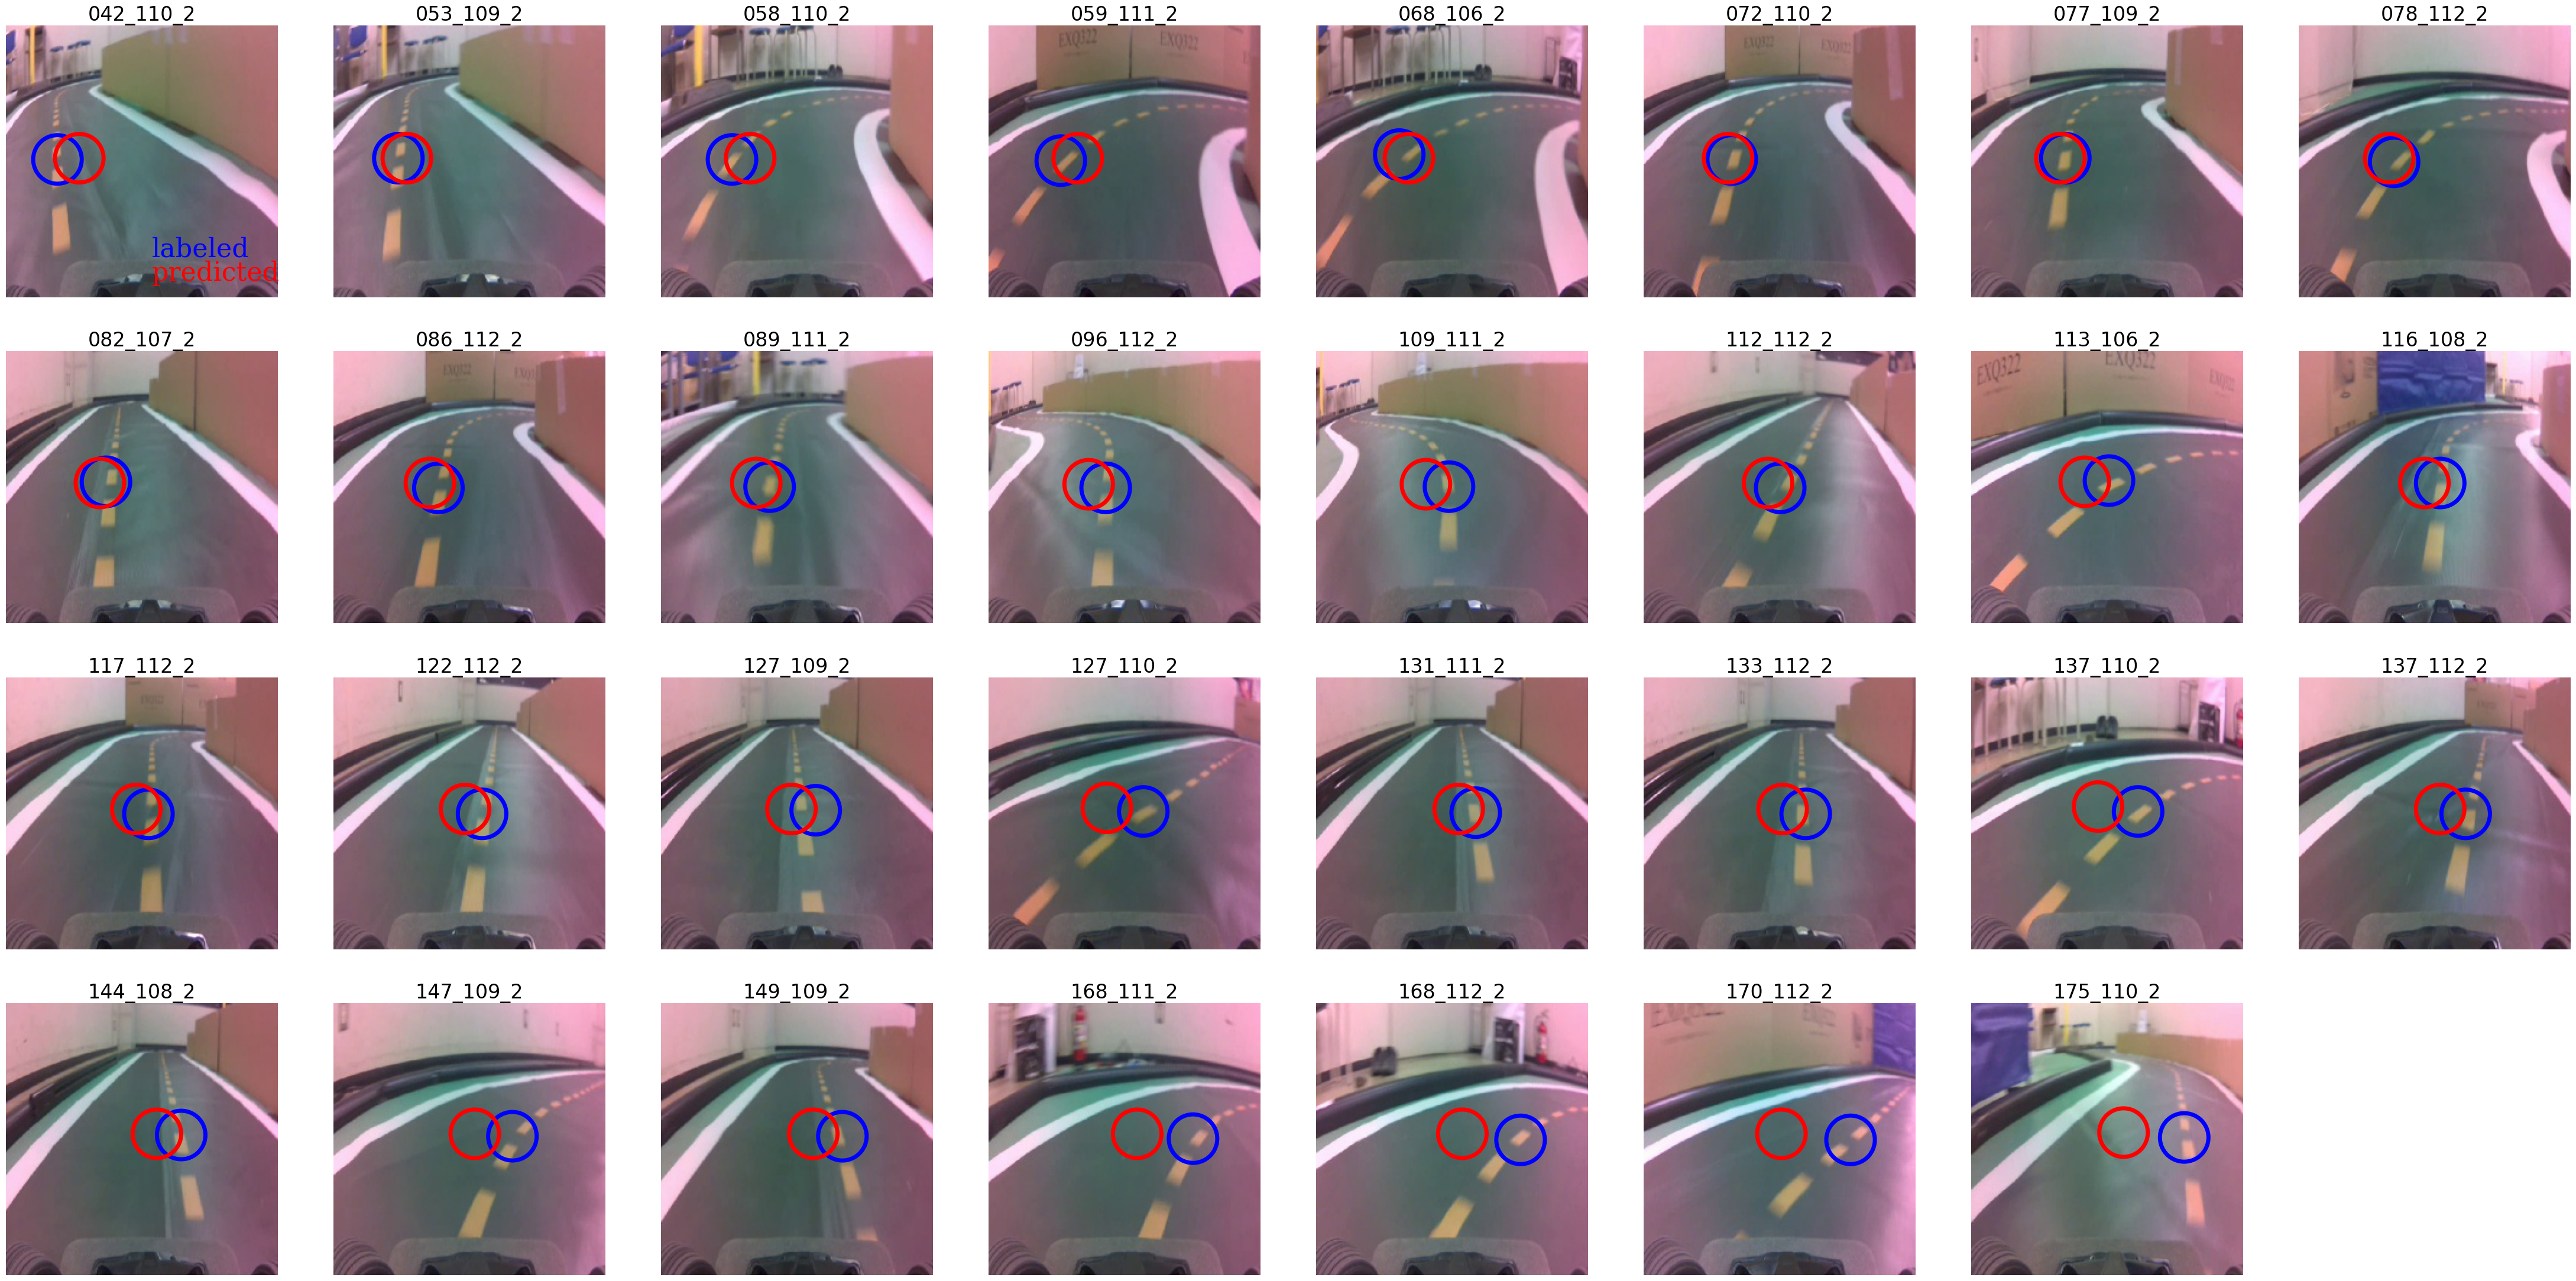

In [5]:
#plt.figure(figsize=(IMG_WIDTH/10, IMG_HEIGHT/10), dpi=100)
plt.figure(figsize=(IMG_WIDTH/HEIGHT, IMG_HEIGHT/WIDTH), dpi=100)

for i, name in enumerate(sorted(filenames)):
    if i >= start_pos:
        if i >= WIDTH * HEIGHT + start_pos:
            break
        pattern = '(\d+)_(\d+).*'
        result = re.match(pattern, name)
        
        
        if result:
            x = result.group(1)
            y = result.group(2)
        
        img = mpimg.imread(path + "/" + name)
        
        preprocessed = preprocess(img)
        output = model(preprocessed).detach().cpu().numpy().flatten()
        result_x = output[0]
        result_y = output[1]
        result_x = int(IMG_WIDTH * (result_x / 2.0 + 0.5))
        result_y = int(IMG_HEIGHT * (result_y / 2.0 + 0.5))
        #print(result_x,result_y)
        
        plt.subplot(HEIGHT,WIDTH,(i-start_pos)+1)
        plt.tick_params(labelbottom=False,labelleft=False)
        plt.tick_params(bottom=False,left=False,right=False,top=False)
        ax = plt.gca() # get current axis
        
        ax.spines["right"].set_color("none") 
        ax.spines["left"].set_color("none") 
        ax.spines["top"].set_color("none")  
        ax.spines["bottom"].set_color("none") 
        c = patches.Circle(xy=(int(x), int(y)), linewidth=5, radius=20, ec='b',fill=False)
        r = patches.Circle(xy=(int(result_x), int(result_y)), linewidth=5, radius=20, ec='r',fill=False)
        ax.add_patch(c)
        ax.add_patch(r)
        
        if i == 0:
            ax.text(120,190, "labeled", color="#0000ff",fontfamily="serif",fontsize=32)
            ax.text(120,210, "predicted", color="#ff0000",fontfamily="serif",fontsize=32)
        
        plt.title(name[0:9],fontsize=24)
        plt.imshow(img)